In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/Documents/Johns Hopkins University/Classes/Fall 2022/pplectures2022/activities

###  Activity 1: All Possible Regressions

This is a quick assignment.  I would expect it to only take a couple of hours to complete. The start of this notebook develops the example.  You will then parallelize the exammple using `joblib`. 

Run this on a machine that has at least 4 cores. Typically this is your laptop. The ugrad machines are also OK. Google Colab is not adequate. Fill out the requested cells toward the bottom of the notebook.

**Due date**: September 16 1, 2022, 5:00 pm EDT.

**Instructions for Submission**: Submit via Gradescope.

#### Preparing the Environment

You will need a couple of packages installed to make this work.  Stop your instance of jupyter lab and then run

```
conda install pandas pandoc
jupyter lab
```
At this point, you should be ready to go.

#### Example code

This is a Python reimplementation of the Section 3.4. in _Matloff_, Parallel Computing for Data Science. It is based on data from https://www.kaggle.com/divan0/multiple-linear-regression. The notebook asks the question what combination of variables best predict the price of a house.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

#importing dataset using panda
dataset = pd.read_csv('../data/kc_house_data.csv')
#to see what my dataset is comprised of
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
#dropping the id and date column
dataset = dataset.drop(['id','date'], axis = 1)

# clean out NaN and inf values
dataset = dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

Let's first do a simple regression. How does square footage predict price? 

In [9]:
from sklearn.linear_model import LinearRegression

X = np.array(dataset.sqft_living)
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],1))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.4928817196006995


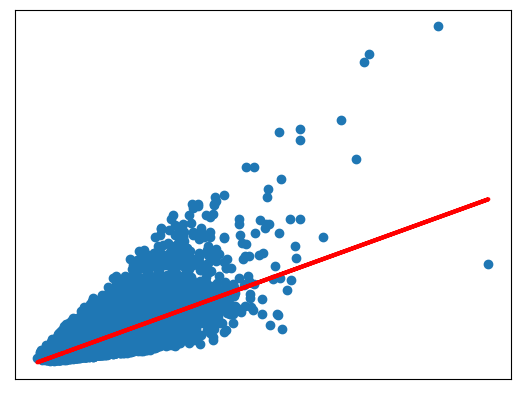

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# scatter data
plt.plot(X,Y,'o')
# best fit line
y_pred = model.intercept_ + model.coef_ * X
plt.plot(X, y_pred, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

We see that there is a strong correlation between square footage and house price.  The coefficient of determination measures the strength of the correlation and varies between 0 (no correlation) and 1.0 (perfectly correlated).

### Multiple Linear Regression

Adding more variables often improves the score.

In [11]:
X = np.array(dataset[['sqft_living','condition','yr_built']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.5249639858277426


but some variables are confounding

In [12]:
X = np.array(dataset[['zipcode','floors','waterfront']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.1358874997770878


This leads to a first parallel program.  What are the right set of variables? A brute force approach called _All Possible Regressions_ examines all combinations. So, let's build a big matrix that and we will regress on subsets.  We will look at all combinations of 1, 2, or 3 variables.

In [13]:
from itertools import combinations, chain

Y = np.array(dataset.price)
X = np.array(dataset.drop(['price'], axis=1))

## Let's choose all combinations of 1, 2, and 3 columns.
col_idxs = np.array(range(X.shape[1]))
combos = list(chain(combinations(col_idxs, 1), combinations(col_idxs, 2), combinations(col_idxs, 3)))

In [14]:
model = LinearRegression()

# do in a for loop (dumbest way)
r_sq_best = 0.0
for combo in combos:
    Xp = X[:,combo]
    model = model.fit(Xp,Y)
    r_sq = model.score(Xp,Y)
    if r_sq > r_sq_best:
        r_sq_best = r_sq
        combo_best = combo
    
print(r_sq_best, combo_best)

0.6095149101819037 (2, 6, 14)


The outcome is kind of crazy. The fields are `sqft-living`, `view`, and `latitude`. Latitude is probably a somewhat accurate proxy for wealth in this area, e.g. N of town richer than south of town. But, this is the kind of outcome that would not translate to other regions, i.e. is likely specific to this data.  _Neat_.

Back to performance.

In [15]:
%%timeit
model = LinearRegression()

r_sq_best = 0.0
for combo in combos:
    Xp = X[:,combo]
    model = model.fit(Xp,Y)
    r_sq = model.score(Xp,Y)
    if r_sq > r_sq_best:
        r_sq_best = r_sq
        combo_best = combo

1.82 s ± 375 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's see if flattening the loop matters. Replace for loop with a list comprehension of all combination of variables.

In [16]:
def r_sq_regression (combo):
    Xp = X[:,combo]
    model = LinearRegression()
    model = model.fit(Xp,Y)
    return model.score(Xp,Y)

In [17]:
r_sq_list = [ (combo, r_sq_regression(combo)) for combo in combos ]
r_sq_arr = np.array(r_sq_list, dtype=object)
r_sq_idx = np.argmax(r_sq_arr[:,1])
print(r_sq_arr[r_sq_idx])

[(2, 6, 14) 0.6095149101819037]


In [18]:
%%timeit
r_sq_list = [ (combo, r_sq_regression(combo)) for combo in combos ]
r_sq_arr = np.array(r_sq_list, dtype=object)
r_sq_idx = np.argmax(r_sq_arr[:,1])

1.6 s ± 65.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It didn't seem to help. But, this is a step toward parallelization.

### Exercise (This is the assignment)

1. Use `joblib.Parallel` and `joblib.delayed` to parallelize the computation of the calls to `r_sq_regression`. 
    1. In one cell, print the answer to verify that your parallel program is correct.
    2. In another cell time the computation. What is the speedup at `n_jobs=4`?
    3. Estimate the Amdahl number for this computation. Show your work.

In [19]:
# TODO code for 1A
from joblib import Parallel, delayed
r_sq_list = Parallel(n_jobs=4)(delayed(r_sq_regression)(combo) for combo in combos)
print(np.max(r_sq_list))
print(combos[np.argmax([r_sq_list])]) # Same results as serial code!

0.6095149101819037
(2, 6, 14)


In [20]:
%%timeit 
# TODO code for 1B 
r_sq_list = Parallel(n_jobs=4)(delayed(r_sq_regression)(combo) for combo in combos) # Code to find argmax, make comparison more fair
np.max(r_sq_list)
combos[np.argmax([r_sq_list])]

650 ms ± 153 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**TODO Answer for 1B**

We see a 1600/650 = <font color="orange">2.46x speedup</font> when running in parallel with n_jobs=4

### TODO 1C Amdahl's Number

$$s_{\text{latency}_s}=\frac{1}{(1-p) + \frac{p}{s}}$$

$$2.46 = \frac{1}{(1-p) + \frac{p}{4}}$$


$$\frac{1}{2.46} = 1-.75p$$

$$.75p = 1-\frac{1}{2.46}$$

$$.75p = .6$$

$$p=0.8$$

2. Use the batch size parameter to vary the number of jobs in each batch from 1,2,...128 @ n_jobs=4. 
   1. Plot your results (use %timeit -o to capture output)
   2. Model the problem as having two performance components: a fixed startup cost per batch ($C_B$) and perfect parallelism.  Estimate the batch startup cost (give a range).
   3. Your answer to the batch startup costs should be noisy, i.e. there is not a consistent estimate for startup costs across all batch sizes. This indicates that a fixed startup cost per batch is not a good model. Consider other startup costs, such as skew, interference, and startup costs (per job). What do you think is a reasonable explanation for the inefficiency? What factors are possible?  Which factors can you eliminate?

In [21]:
time=[]

In [22]:
%%timeit -o
# code for 2A
r_sq_list = Parallel(n_jobs=4, batch_size=1)(delayed(r_sq_regression)(combo) for combo in combos)

727 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 727 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [23]:
time.append(_)

In [24]:
%%timeit -o
r_sq_list = Parallel(n_jobs=4, batch_size=2)(delayed(r_sq_regression)(combo) for combo in combos)

681 ms ± 80.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 681 ms ± 80.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [25]:
time.append(_)

In [26]:
%%timeit -o
r_sq_list = Parallel(n_jobs=4, batch_size=4)(delayed(r_sq_regression)(combo) for combo in combos)

665 ms ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 665 ms ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [27]:
time.append(_)

In [28]:
%%timeit -o
r_sq_list = Parallel(n_jobs=4, batch_size=8)(delayed(r_sq_regression)(combo) for combo in combos)

568 ms ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 568 ms ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [29]:
time.append(_)

In [30]:
%%timeit -o
r_sq_list = Parallel(n_jobs=4, batch_size=16)(delayed(r_sq_regression)(combo) for combo in combos)

535 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 535 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [31]:
time.append(_)

In [32]:
%%timeit -o
r_sq_list = Parallel(n_jobs=4, batch_size=32)(delayed(r_sq_regression)(combo) for combo in combos)

596 ms ± 79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 596 ms ± 79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [33]:
time.append(_)

In [34]:
%%timeit -o 
r_sq_list = Parallel(n_jobs=4, batch_size=64)(delayed(r_sq_regression)(combo) for combo in combos)

555 ms ± 41.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 555 ms ± 41.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [35]:
time.append(_)

In [36]:
%%timeit -o
r_sq_list = Parallel(n_jobs=4, batch_size=128)(delayed(r_sq_regression)(combo) for combo in combos)

533 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 533 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [37]:
time.append(_)

Text(0.5, 0, '2^x - log scale')

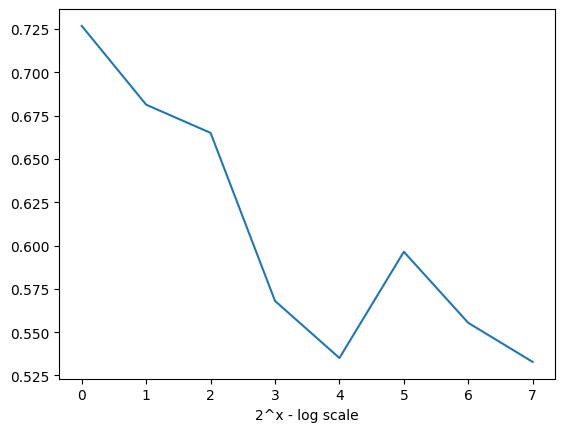

In [47]:
%matplotlib inline

avg_times=[t.average for t in time]
ticks = [1,2,4,8,16,32,64,128]
x_vals = [np.log2(x) for x in ticks]
dict_times = dict(zip(ticks,avg_times))
plt.plot(x_vals,avg_times)
plt.xticks(x_vals)
plt.xlabel("2^x - log scale")
# TODO plot for 2A

In [39]:
print(len(combos))

987


In [48]:
dict_times

{1: 0.7267218571443144,
 2: 0.6812603808565265,
 4: 0.6649969285697027,
 8: 0.568015571714828,
 16: 0.535081618998707,
 32: 0.5963909760019825,
 64: 0.5553671249997153,
 128: 0.5328165477154211}

In [49]:
# code for 2B
startup_cost_1_2 = np.absolute(dict_times[2] - dict_times[1]) / (np.ceil(len(combos)/2))
startup_cost_2_4 = np.absolute(dict_times[4] - dict_times[2]) / (np.ceil(len(combos)/4)) # See below for exp
startup_cost_4_8 = np.absolute(dict_times[8] - dict_times[4]) / (np.ceil(len(combos)/8))
startup_cost_8_16 = np.absolute(dict_times[16] - dict_times[8]) / (np.ceil(len(combos)/16))
startup_cost_16_32 = np.absolute(dict_times[32] - dict_times[16]) / (np.ceil(len(combos)/32)) # See below for exp
startup_cost_32_64 = np.absolute(dict_times[64] - dict_times[32]) / (np.ceil(len(combos)/64))
startup_cost_64_128 = np.absolute(dict_times[128] - dict_times[64]) / (np.ceil(len(combos)/128))
print("Startup cost per each element 1-2: ", startup_cost_1_2)
print("Startup cost per each element 2-4: ", startup_cost_2_4)
print("Startup cost per each element 4-8: ", startup_cost_4_8)
print("Startup cost per each element 8-16: ", startup_cost_8_16)
print("Startup cost per each element 16-32: ", startup_cost_16_32)
print("Startup cost per each element 32-64: ", startup_cost_32_64)
print("Startup cost per each element 64-128: ", startup_cost_64_128)

Startup cost per each element 1-2:  9.202727993479322e-05
Startup cost per each element 2-4:  6.584393638390202e-05
Startup cost per each element 4-8:  0.0007821077165715705
Startup cost per each element 8-16:  0.0005311927857438868
Startup cost per each element 16-32:  0.0019777211936540503
Startup cost per each element 32-64:  0.0025639906876417026
Startup cost per each element 64-128:  0.002818822160536777


**TODO Answer for 2B**

I notice that the runtime decreases heavily until 64 batch_size, but then slightly goes up when switching to 128. I
assume this trend reversal is because of startup cost. Hence, to calculate cost-per-element:

$$\frac{time(batch2^{i+1})-time(batch2^{i})}{num\_batches}$$

I have applied this formula to all batch sizes. Since we have 987 items in combos, then for 32-batch size, we'd have 31 batches ($\ceil \frac{987}{32}$)
corresponding nr. batches to get the batch startup cost.
.

For 64: 16 batches.

For 128: 8 batches. etc. We have to divide the time by the corresponding nr. batches to get Startup cost


Range of batch startup cost: $[0.0005665 − 0.00188]$ seconds 


Our model says that there is a single thread/process that does all the startup work/do this fork-join (building the
list in Delayed() that is handed to Parallel()), and that we'd have a linear cost wrt. the size of this list.

This is not a good model, and the data doesn't fit it (see graph going up at 128, also our range being rather
wide). Looking at output of cell above: cost decreases from 1-2, but then starts increasing again, and at the last
point it jumps significantly. This is clearly not linear.

## TODO Answer for 2C

Your answer to the batch startup costs should be noisy, i.e. there is not a consistent estimate for startup costs across all batch sizes. This indicates that a fixed startup cost per batch is not a good model. Consider other startup costs, such as skew, interference, and startup costs (per job). What do you think is a reasonable explanation for the inefficiency? What factors are possible?  Which factors can you eliminate?


There are many possible answers to this problem. Here's mine:


Startup: the startup cost would be splitting the regression task list (combos) & distriting those tasks to workers. This would be expected to increase as batch size increases


Interference: This seems unlikely. Interference implies several workers competing for the same resource, e.g. many threads competing for the GIL in Python, or acquiring locks in order to write to memory (in a later lecture), or processes competing for limited memory bandwidth. Here, resources only read their own batches of data, and there is no write contention.


Skew: Again, unlikely. Skew means there is a long-running worker(s), whose output you depend on. Here, each worker is given exactly the same batch size and should finish at roughly the same time. Although One of the last batches will be incomplete (987 items / 128 batch_size = 7.71), meaning 3 workers will have full 128-size batches, and one worker 91-size batch, this should be insignificant in the grand scheme of the whole computation

3. Run the job with `prefer='threads'` and `prefer='processes'`. Given that `LinearRegression.fit()`
    1. Which is more efficient?  Why? Consider our discussion of parallel threads in python.
    2. Can you conclude that `LinearRegression.fit()` does or does not release the GIL? Explain.

_Note_: you can verify this conclusion by calling `LinearRegression.fit()` directly, rather than call the wrapper functions `r_sq_regression`.

In [50]:
%%timeit
# Code for 3
r_sq_list = Parallel(n_jobs=4, prefer='threads')(delayed(r_sq_regression)(combo) for combo in combos)

3.89 s ± 201 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit
r_sq_list = Parallel(n_jobs=4, prefer='processes')(delayed(r_sq_regression)(combo) for combo in combos)

716 ms ± 154 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Running LinReg.fit manually

In [53]:
#IwasgettingweirdresultscallingLinearRegression.fit()manually,soIusedthissuggestionfromPiazza # https://piazza.com/class/ksxhsr5ejw83dj?cid=72
from joblib import Parallel, delayed
def r_sq_regression_no_score (combo):
    Xp = X[:,combo]
    model = LinearRegression()
    model = model.fit(Xp,Y)
    return #model.score(Xp,Y)

In [56]:
%%timeit
r_sq_list = Parallel(n_jobs=4, prefer='threads')(delayed(r_sq_regression_no_score)(combo) for combo in combos)

1 s ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
%%timeit
r_sq_list = Parallel(n_jobs=4, prefer='processes')(delayed(r_sq_regression_no_score)(combo) for combo in combos)

472 ms ± 8.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**TODO Answer to 3**

<font color="orange">a) Which is more efficient?</font>

The results show that Processes are more efficent than threads (about 2x in my case). This happens because processes each have their own separate Python runtime, and therefore their own GIL, whereas threads have to compete for the same GIL.

<font color="orange">b) What can you conclude about the GIL?</font>

Reading from the joblib User Guide:
"When you know that the function you are calling is based on a compiled extension that releases the Python Global Interpreter Lock (GIL) during most of its computation then it is more efficient to use threads instead of Python processes as concurrent workers. For instance this is the case if you write the CPU intensive part of your code inside a with nogil block of a Cython function."

Since the results show us that Processes is significantly faster, that would suggest that the implementation of LinearRegression.fit() does not release the GIL, making the threads have to compete for it, and therefore the threads backend is slower. We can confirm results stay consistent when calling the stripped-down r_sq_regression()